# DataLoader Example

This notebook shows how to use `torch.utils.data.DataLoader`, a tool to perform parallel data read and preprocessing.

## 1. Basics of data loading

Let's create a simple "dataset", an array of length 100. 

In [1]:
import numpy as np

data = np.arange(100)

For ML training with stochastic gradient descent, we want to batch a subset of data and load iteratively.

This is what DataLoader does for you.

In [2]:
from torch.utils.data import DataLoader
loader = DataLoader(data,batch_size=10)

for batch_index, batch_data in enumerate(loader):

    print('Batch',batch_index,'with data',batch_data)

Batch 0 with data tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Batch 1 with data tensor([10, 11, 12, 13, 14, 15, 16, 17, 18, 19])
Batch 2 with data tensor([20, 21, 22, 23, 24, 25, 26, 27, 28, 29])
Batch 3 with data tensor([30, 31, 32, 33, 34, 35, 36, 37, 38, 39])
Batch 4 with data tensor([40, 41, 42, 43, 44, 45, 46, 47, 48, 49])
Batch 5 with data tensor([50, 51, 52, 53, 54, 55, 56, 57, 58, 59])
Batch 6 with data tensor([60, 61, 62, 63, 64, 65, 66, 67, 68, 69])
Batch 7 with data tensor([70, 71, 72, 73, 74, 75, 76, 77, 78, 79])
Batch 8 with data tensor([80, 81, 82, 83, 84, 85, 86, 87, 88, 89])
Batch 9 with data tensor([90, 91, 92, 93, 94, 95, 96, 97, 98, 99])


Well, for a stochastic sampling, turn on `shuffle=True`

In [3]:
loader = DataLoader(data,batch_size=10,shuffle=True)

for batch_index, batch_data in enumerate(loader):

    print('Batch',batch_index,'with data',batch_data)

Batch 0 with data tensor([36, 91, 48, 25, 85,  9,  6, 30, 56, 93])
Batch 1 with data tensor([66, 34, 83, 29, 46, 75, 43, 79, 51, 20])
Batch 2 with data tensor([42, 49, 52, 33, 22, 82, 19, 81, 31, 68])
Batch 3 with data tensor([90, 55,  1, 17, 99, 73, 64, 41, 96, 71])
Batch 4 with data tensor([18, 70, 35, 32, 24, 95, 65, 14, 59, 50])
Batch 5 with data tensor([74, 44, 67, 62, 21, 88,  2, 92, 54, 39])
Batch 6 with data tensor([78, 26, 53, 10, 89, 12,  8, 37,  0, 11])
Batch 7 with data tensor([ 3, 60, 77, 27, 98, 58, 40, 45, 57, 80])
Batch 8 with data tensor([47, 84, 63,  4, 28, 13, 23, 87, 72, 94])
Batch 9 with data tensor([97, 86, 15, 16, 61, 38,  5, 76, 69,  7])


## 2. Parallelized data loading

In reality, dataset is typically large and needs to be read from a file occassionally (i.e. the whole data won't fit in memory).
Interaction with a file storage to read data can take time. 

A dummy `dataset` class below exaggerate this effect by `time.sleep(1)` for every data access.

In [4]:
import time
import numpy as np

class dataset:
    
    def __init__(self):
        self._data = np.arange(1e9).reshape(100,-1)

    def __len__(self):
        return len(self._data)
    
    def __getitem__(self,index):
        time.sleep(1)
        return self._data[index]


Now let's run a data loader and measure two time periods:
1. The time that takes to read data into CPU memory
2. The time that takes to move data to GPU memory

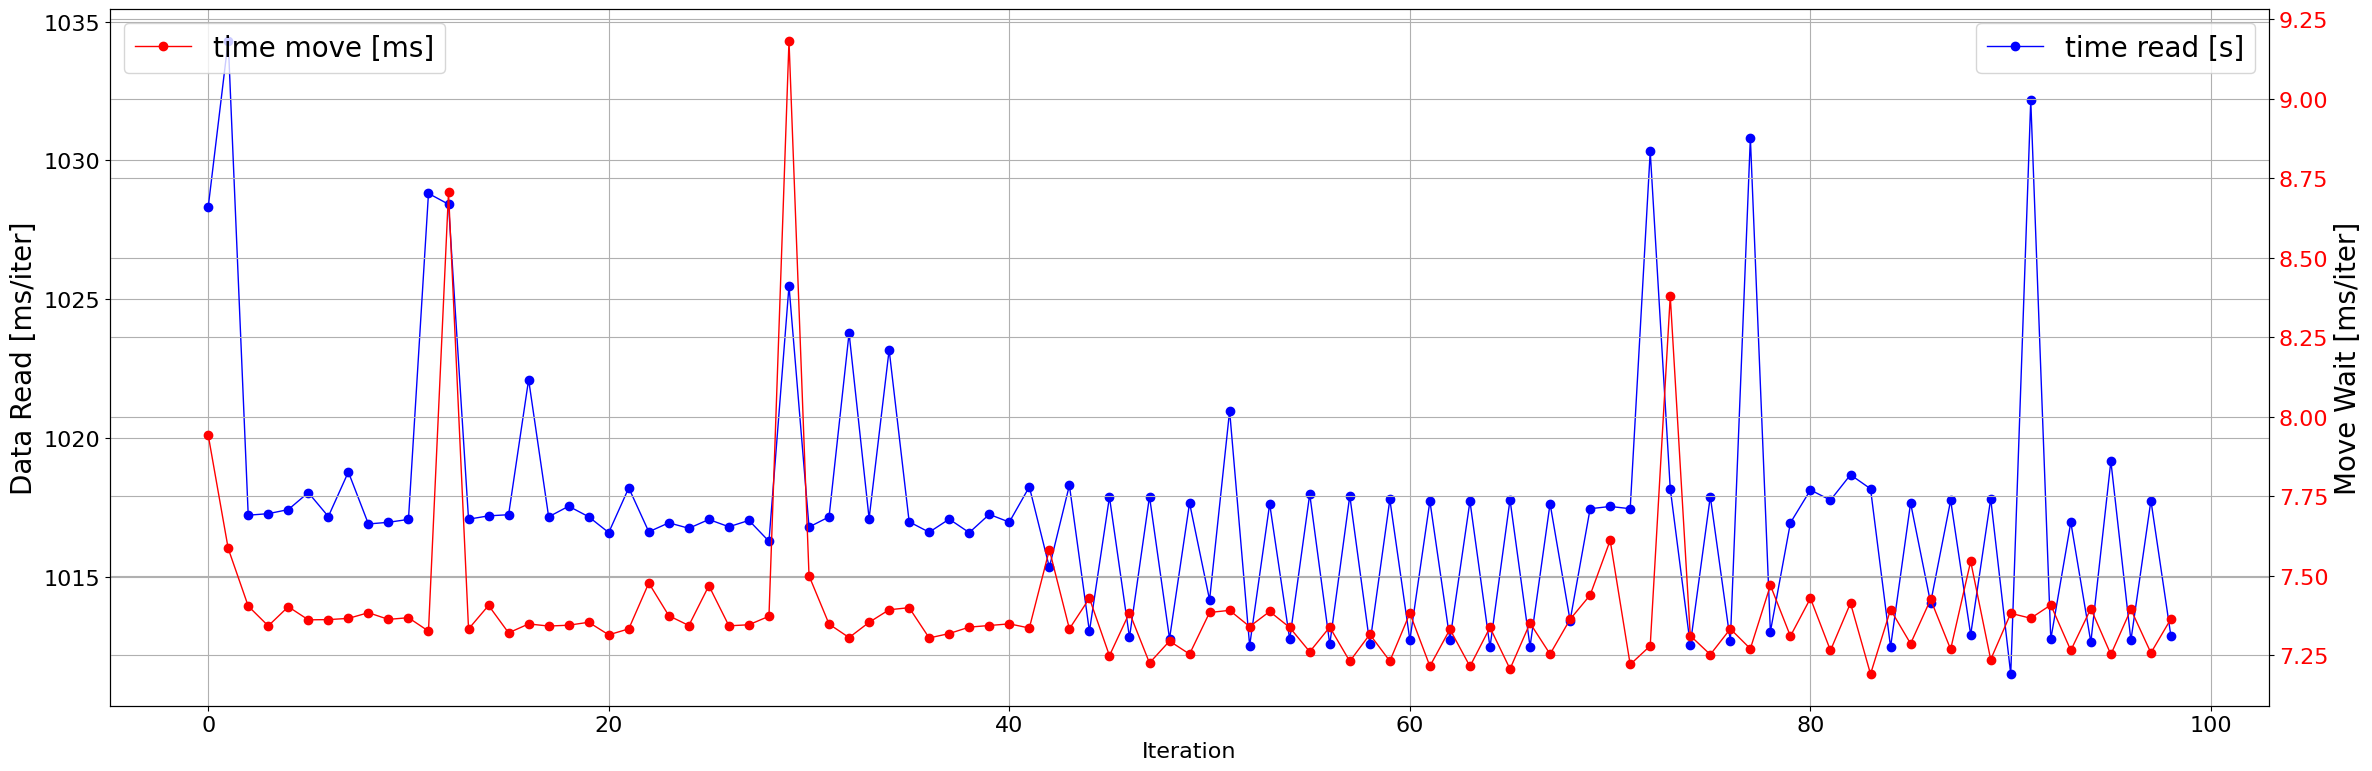

In [5]:
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.figsize'] = [8, 6]
mpl.rcParams['font.size'] = 16
mpl.rcParams['axes.grid'] = True

def run_iterations(loader):

    t0=time.time()
    load_time=[]
    move_time=[]
    for index, batch_data in enumerate(loader):
    
        isum=batch_data.sum()
        t1=time.time()
        load_time.append(t1-t0)
    
        torch_data = batch_data.to('cuda')
        isum=torch_data.sum().item()
        t0=time.time()
        move_time.append(t0-t1)
        
    return np.array([load_time,move_time])


def run_and_plot(loader):
    
    ts=run_iterations(loader)
    
    fig,ax0=plt.subplots(figsize=(24,8))
    ax0.plot(ts[0][1:]*1000,linewidth=1,marker='o',label='time read [s]',color='blue')
    ax0.set_xlabel('Iteration')
    ax0.set_ylabel('Data Read [ms/iter]',fontsize=20)
    
    ax1=ax0.twinx()
    ax1.plot(ts[1][1:]*1000,linewidth=1,marker='o',label='time move [ms]',color='red')
    ax1.tick_params(axis='y', labelcolor='red')
    ax1.set_ylabel('Move Wait [ms/iter]',fontsize=20)
    fig.tight_layout()
    ax0.legend(loc=0,fontsize=20)
    ax1.legend(loc=2,fontsize=20)
    plt.show()

# Create a dataset and run a data loader
    
data = dataset()

from torch.utils.data import DataLoader
loader = DataLoader(data,batch_size=1,shuffle=True)

run_and_plot(loader)


Next, let's parallelize by specifying `num_workers=10` 

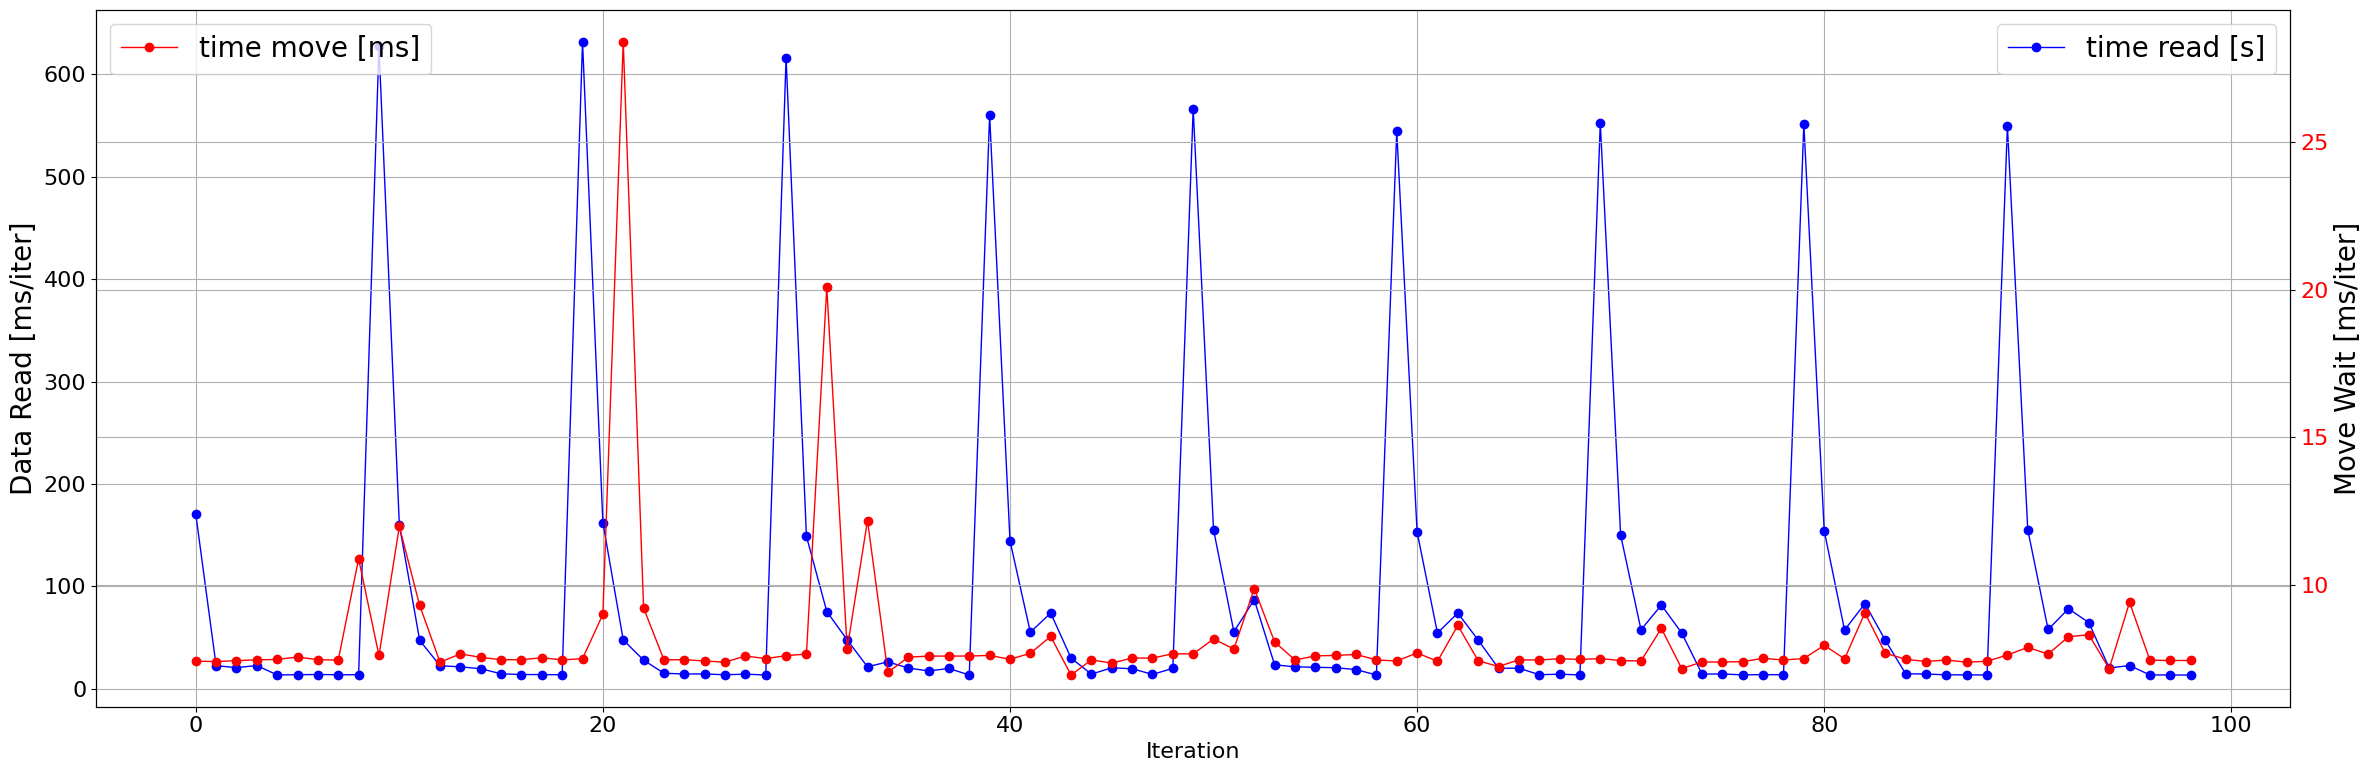

In [6]:
loader = DataLoader(data,batch_size=1,shuffle=True,num_workers=10)

run_and_plot(loader)

Finally, we can also exploit a trick of pinning the memory used for loading data (`pin_memory=True`), particularly effective when the size is identical across batch.

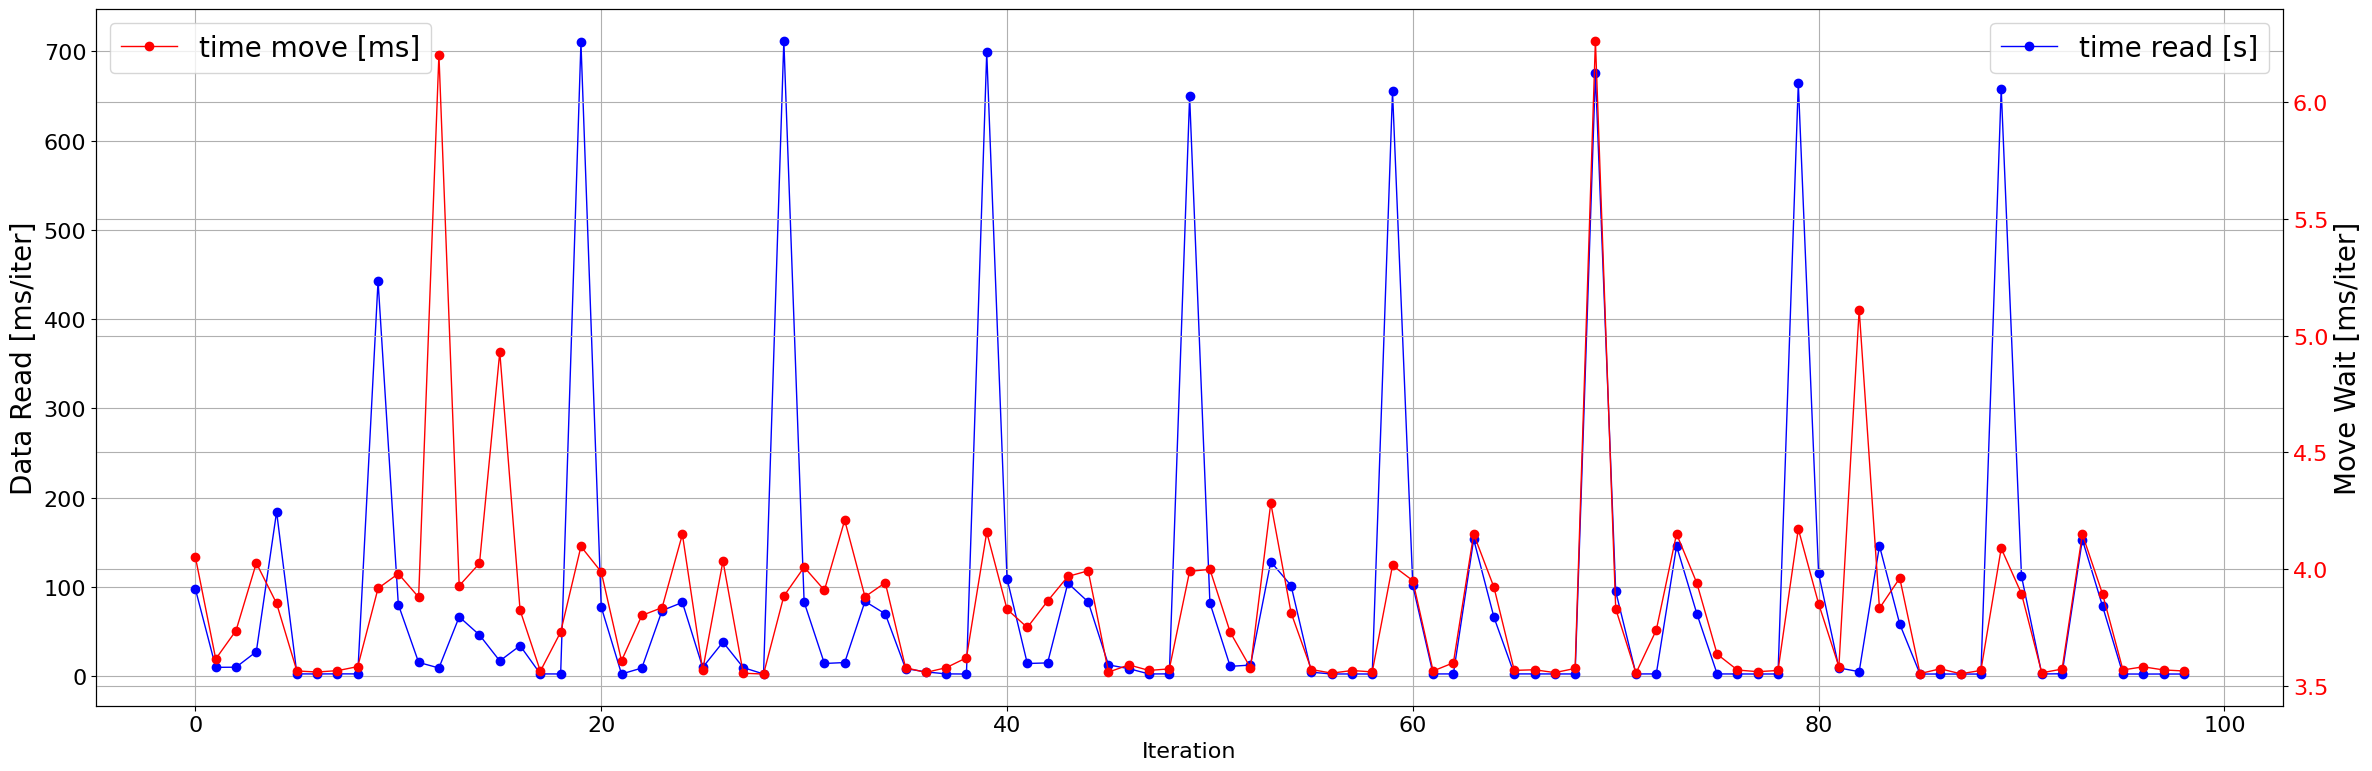

In [7]:
loader = DataLoader(data,batch_size=1,shuffle=True,num_workers=10,pin_memory=True)

run_and_plot(loader)